# Import the necessary libraries

In [95]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os

# Load the MNIST dataset

In [96]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [97]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = "cpu"

# Model Preparation

In [98]:
class VerySimpleNet(nn.Module):
    def __init__(self, hidden_size_1=100, hidden_size_2=100):
        super(VerySimpleNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
net = VerySimpleNet().to(device)
net

## Train the model

In [ ]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28*28))
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return
            
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')

MODEL_FILENAME = 'simplenet_ptq.pt'

if Path(MODEL_FILENAME).exists():
    net.load_state_dict(torch.load(MODEL_FILENAME))
    print('Loaded model from disk')
else:
    train(train_loader, net, epochs=1)
    # Save the model to disk
    torch.save(net.state_dict(), MODEL_FILENAME)

## Define the testing loop

In [101]:
def test(model: nn.Module, total_iterations: int = None):
    correct = 0
    total = 0

    iterations = 0

    model.eval()

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                total +=1
            iterations += 1
            if total_iterations is not None and iterations >= total_iterations:
                break
    print(f'Accuracy: {round(correct/total, 3)}')

In [ ]:
print('Size of the model before quantization')
print_size_of_model(net)

In [ ]:
print(f'Accuracy of the model before quantization: ')
test(net)

In [ ]:
test_sample = test_loader.dataset[0]
test_sample_img = test_sample[0].to(device)
test_sample_label = test_sample[1]

print('Test sample label:', test_sample_label)  # Print actual label
print('Test sample image shape:', test_sample_img.shape)  # Print image shape

## Print weights and size of the model before quantization

In [ ]:
# Print the weights matrix of the model before quantization
print('Weights before quantization')
print(net.linear1.weight)
print(net.linear1.weight.dtype)
print(net.linear1.weight.shape)
print(net.linear1.bias)

# Static Quantization w/o Layer Fusion


## Insert min-max observers in the model

In [106]:
class QuantizedVerySimpleNet(nn.Module):
    def __init__(self, hidden_size_1=100, hidden_size_2=100):
        super(QuantizedVerySimpleNet,self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.quant(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.dequant(x)
        return x

In [ ]:
if torch.backends.quantized.engine == "x86":
    print("PyTorch is using the x86 quantization backend")
else:
    print("PyTorch is not using the x86 quantization backend")

In [ ]:
net_quantized = QuantizedVerySimpleNet().to(device)
net_quantized.load_state_dict(net.state_dict())
net_quantized.eval()

In [ ]:
net_quantized = QuantizedVerySimpleNet().to(device)
# Copy weights from unquantized model
net_quantized.load_state_dict(net.state_dict())
net_quantized.eval()

I have used default configurations for the observers and quantizers. You can also customize the configurations as per your requirements using the `qconfig` parameter. Refer to the [documentation](https://pytorch.org/docs/stable/generated/torch.ao.quantization.qconfig.QConfig.html) for more details.

The pytorch defualt configurations for an x86 CPU are as follows:
* Weight observer: MinMaxObserver
* Activation observer: MinMaxObserver
* Weight quantizer: SymmetricQuantizer (qint8, range -127 to 127)
* Activation(or input) quantizer: AsymmetricQuantizer (quint8, range 0 to 127). However, if you are using an x86 backend, the default quantizer for activations in PyTorch uses 7-bit quantization (range 0 to 127) instead of 8-bit quantization (range 0 to 255). This is recommended to avoid any overflow issues during computation. Refer to the [documentation](https://pytorch.org/docs/stable/quantization.html#quantization-aware-training) for more details.





In [ ]:
my_config = torch.ao.quantization.default_qconfig
# my_config = torch.quantization.QConfig(activation=torch.quantization.default_observer,
                                    #    weight=torch.quantization.default_weight_observer)
net_quantized.qconfig = my_config
print(net_quantized.qconfig)
net_quantized = torch.ao.quantization.prepare(net_quantized) # Insert observers
net_quantized

## Calibrate the model using the test set

In [ ]:
test(net_quantized)

In [ ]:
print(f'Check statistics of the various layers')
net_quantized

## Quantize the model using the statistics collected

In [113]:
net_quantized = torch.ao.quantization.convert(net_quantized)

In [ ]:
print(f'Check statistics of the various layers')
net_quantized

## Print weights of the model after quantization

Note that the weights are now quantized to 8-bit integers, but the bias values remain in floating-point format. This is because PyTorch does not quantize bias values by default. Instead, they are quantized during inference as 32-bit integers (int32).

In [ ]:
# Print the weights matrix of the model after quantization
print('Weights after quantization')
print(net_quantized.linear1.weight().int_repr())  # Access the quantized weights
print(net_quantized.linear1.bias())  # Access the quantized bias


## Perform custom quantization on linear layer 1

Using the function quantize_params and quantize tensor, we will quantize the weights, activations and bias of linear layer 1. Then we will perform the matrix multiplication and addition operation using the quantized values to get the quantized output tensor. The values obtained are then compared with the quantized values obtained using the PyTorch's quantization functions.

The equations used for quantization are as follows (the pictures are taken from the slides provided by Umar Jamil):


Symmetric quantization:

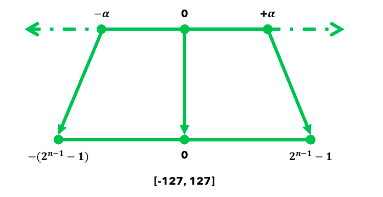


$$ alpha = max(|min_{tensor}|, |max_{tensor}|) $$
$$ beta = -alpha $$
$$ qmax = 2^{bitwidth - 1} - 1 $$
$$ qmin = -qmax $$
$$ scale = \frac{alpha-beta}{qmax-qmin} $$
$$ zero_{point} = 0 $$
$$ quantized\_tensor = round(\frac{tensor}{scale}) $$
$$ quantized\_tensor = clip(quantized\_tensor, qmin, qmax) $$
$$ dequantized\_tensor = quantized\_tensor \times scale $$


Asymmetric quantization:

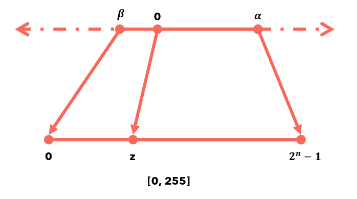

$$ alpha = max_{tensor} $$
$$ beta = min_{tensor} $$
$$ qmax = 2^{bitwidth} - 1 $$
$$ qmin = 0 $$
$$ scale = \frac{alpha-beta}{qmax-qmin} $$
$$ zero_{point} = round(qmin - \frac{beta}{scale}) $$
$$ quantized\_tensor = round(\frac{tensor}{scale} + zero_{point}) $$
$$ quantized\_tensor = clamp(quantized\_tensor, qmin, qmax) $$
$$ dequantized\_tensor = (quantized\_tensor - zero_{point}) \times scale $$



Note that by default, PyTorch uses symmetric quantization for weights and asymmetric quantization (affine quantization) for activations.

Activation quantization is asymmetric because activation values are typically non-negative, hence the quantized range does not need to include negative values. Using symmetric quantization for activations can lead to poor quantization resolution, as the clipping range would include values that never appear in the input, reducing precision. This issue is illustrated in the image below.

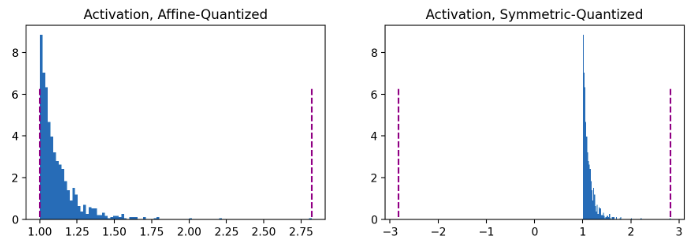


In [116]:
# Function to find the scale and zero point for quantization
def quantize_params(symmetric: bool = True, num_bits: int = 8,layer: nn.Module = None,  min_val: float = None, max_val: float = None):    
    if min_val is None:
        min_val = torch.min(layer.weight).item()
    if max_val is None:
        max_val = torch.max(layer.weight).item()
    if symmetric:
        # Find the maximum absolute value
        max_val = max(abs(min_val), abs(max_val))
        min_val = -max_val
        qmin = -(2 ** (num_bits - 1)-1)
        qmax = 2 ** (num_bits - 1) - 1
        scale = (max_val - min_val) / (qmax - qmin)
        zero_point = 0
    else:
        qmin = 0
        qmax = (2 ** num_bits) - 1
        scale = (max_val - min_val) / (qmax - qmin)
        zero_point = round(qmin - min_val / scale)
    
    return scale, zero_point, qmax, qmin

# Quantize the tensors(weights,bias or activations)
def quantize_tensor(x: torch.Tensor, scale: float, zero_point: int, qmax: int, qmin: int):
    x = torch.round(x / scale + zero_point).clamp(qmin, qmax)
    return x

In [ ]:
# Scale and zero point for the weights obtained using linear1 layer of unquantized model
w_scale, w_zero_point,w_qmax, w_qmin = quantize_params(symmetric=True, num_bits=8, layer=net.linear1,min_val=None, max_val=None)
print('Scale:', w_scale)
print('Zero point:', w_zero_point)

# Quantize the weights of the linear1 layer
qw = quantize_tensor(net.linear1.weight, w_scale, w_zero_point, w_qmax, w_qmin)
print('Quantized weight:', qw)

In [ ]:
# loop through the test_loader and find the min and max values
min_val = 10000
max_val = -10000
for data in tqdm(test_loader, desc='Finding min/max values'):
    x, y = data
    x = x.to(device)
    min_val = min(min_val, torch.min(x).item())
    max_val = max(max_val, torch.max(x).item())

print('Min value:', min_val)
print('Max value:', max_val)

# Scale and zero point for the input tensor (activation) 
x_scale, x_zero_point, x_qmax, x_qmin = quantize_params(symmetric=False, num_bits=7, layer=None, min_val=min_val, max_val=max_val)

# Quantize the input tensor
qx = quantize_tensor(test_sample_img.view(-1, 28*28), x_scale, x_zero_point, x_qmax, x_qmin)
print('Quantized input:', qx)

As discussed earlier, PyTorch does not quantize bias values by default. Instead, they are quantized during inference as 32-bit integers (int32). This approach is necessary because the product of two 8-bit integers (weights and activations) can exceed the range of an 8-bit integer and hence it is stored in a 32-bit accumulator. Since the bias values are added to this intermediate accumulator, int32 is used as the default data type for bias quantization.

Per equation (11) in the [paper](https://arxiv.org/abs/1712.05877), the quantized scale  and zero-point values for the bias are as follows:

$$ scale_{bias} = scale_{weight} \times scale_{activation} $$
$$ zero_{point_{bias}} = 0 $$

In [ ]:
bias = net.linear1.bias
bias_scale = w_scale * x_scale
qbias = torch.round(bias / bias_scale)
print('Quantized bias:', qbias)

In [ ]:
# find the scale and zero point for the output, loop through the test data , pass it through the linear1 layer of the unquantized model and find the min and max values
min_val = 100000
max_val = -100000
for data in tqdm(test_loader, desc='Finding min/max values'):
    x, y = data
    x = x.to(device)
    output = net.linear1(x.view(-1, 784))
    min_val = min(min_val, torch.min(output).item())
    max_val = max(max_val, torch.max(output).item())

print('Min value:', min_val)
print('Max value:', max_val)

# Scale and zero point for the output tensor
output_scale, output_zero_point, output_qmax, output_qmin = quantize_params(symmetric=False, num_bits=7, layer=None, min_val=min_val, max_val=max_val)
print('Output scale:', output_scale)
print('Output zero point:', output_zero_point)
    

The following cell mimics the calculation of quantized output of a linear layer using the quantized weights, activations and bias values. The output is then compared with the output obtained using PyTorch's quantization functions.

I have tried here to explain the calculation of quantized output of a linear layer using the quantized weights, activations and bias values. Refer to equations (2), (3) and (4) in the [paper](https://arxiv.org/abs/1712.05877) for more details.

We know that the calculation of the output of a linear layer is given by:

$$
y = Wx + b
$$

Where:
- \( W \) is the weight matrix,
- \( x \) is the input tensor (activation),
- \( b \) is the bias tensor,
- \( y \) is the output tensor.

The matrix multiplication between \( W \) and \( x \) is done by accumulating the sum of the product of each element of \( W \) and \( x \). Then the bias tensor is added to the output tensor. By definition of matrix multiplication, the \( i \)-th element of the output tensor is given by:

$$
r_Y[0][i] = \sum_{j=0}^{N-1} r_X[0][j] \cdot r_W[i, j] + r_{bias}[i]
$$

Where:
- \( N \) is the number of dimensions in the input tensor (for example, 784 for the MNIST dataset when flattened),
- \( r_Y[0][i] \) is the real-valued output of matrix multiplication at the \( i \)-th neuron of the output layer (there are 100 neurons in the first linear layer of our model),
- \( r_X[0][j] \) is the real-valued input (activation) at the \( j \)-th dimension of the input layer,
- \( r_W[i, j] \) is the real-valued weight at the \( i \)-th neuron corresponding to the \( j \)-th dimension of the input layer.
- \( r_{bias}[i] \) is the real-valued bias at the \( i \)-th neuron of the output layer.


Now, we know real-valued (floating point) values of tensor can be obtained back from the quantized values using the following equation:
$$ r = S \cdot (q - z) $$

Where:
- \( r \) is the real-valued tensor (floating point),
- \( q \) is the quantized tensor (integer),
- \( z \) is the zero point of the quantized tensor,
- \( S \) is the scale of the quantized tensor.

Substituting the real-valued values in terms of quantized values, the equation changes to:

$$
S_Y \cdot (q_Y[0][i] - z_Y) = \sum_{j=0}^{N-1} S_X \cdot (q_X[0][j] - z_X) \cdot S_W \cdot (q_W[i, j] - z_W) + S_{bias} \cdot (q_{bias}[i] - z_{bias})
$$

Here:
- \( S_Y \), \( S_X \), \( S_W \), and \( S_bias \) are the scales for the output, input, weights, and bias respectively. Note that $S_{bias} = S_{X} \times S_{W}.$
- \( z_Y \), \( z_X \), \( z_W \), and \( z_bias \) are the zero points for the output, input, weights, and bias respectively.


Rearranging the terms, we get:

$$
q_Y[0][i] = z_Y + M (\sum_{j=0}^{N-1} (q_X[0][j] - z_X) \cdot (q_W[i, j] - z_W) + (q_{bias}[i] - z_{bias}))
$$

Where:

$$
M = \frac{S_X \cdot S_W}{S_Y}
$$






In [ ]:
# Initialize output tensor with int32
qoutput = torch.zeros(qx.shape[0], qw.shape[0], dtype=torch.int32)
print(qx.shape)
print(qw.shape)
print(qoutput.shape)

for i in range(qw.shape[0]):  # for each output neuron
    acc = 0
    for j in range(qx.shape[1]):
        acc += (qx[0, j].item() - x_zero_point) * (qw[i, j].item() - w_zero_point)
    # Add bias for this neuron
    qoutput[0, i] = acc + qbias[i]

# Apply scaling factors and quantization
qoutput = torch.round(qoutput * x_scale * w_scale / output_scale) + output_zero_point 
qoutput = torch.clamp(qoutput, 0, 127) # Clamp to 7 bit quantization range since I am using a x86 backend
print(qoutput)

In [ ]:
# verfiy the  scale and zero point values obtained using pytorch and custom quantization
w_scale_pytorch = net_quantized.linear1.weight().q_scale()
w_zero_point_pytorch = net_quantized.linear1.weight().q_zero_point()

x_scale_pytorch = net_quantized.quant.scale.item()
x_zero_point_pytorch = net_quantized.quant.zero_point.item()

output_scale_pytorch = net_quantized.linear1.scale
output_zero_point_pytorch = net_quantized.linear1.zero_point

print(f'weight scale based on pytorch: {w_scale_pytorch} and weight zero point based on pytorch: {w_zero_point_pytorch}')
print(f'weight scale based on custom quantization: {w_scale} and weight zero point based on custom quantization: {w_zero_point}')

print(f'input scale based on pytorch: {x_scale_pytorch} and input zero point based on pytorch: {x_zero_point_pytorch}')
print(f'input scale based on custom quantization: {x_scale} and input zero point based on custom quantization: {x_zero_point}')

print(f'output scale based on pytorch: {output_scale_pytorch} and output zero point based on pytorch: {output_zero_point_pytorch}')
print(f'output scale based on custom quantization: {output_scale} and output zero point based on custom quantization: {output_zero_point}')


In [ ]:
# verify the quantized output obtained using pytorch and custom quantization
qx = net_quantized.quant(test_sample_img.view(-1, 784))
print(qx.shape)
output_pytorch = net_quantized.linear1(qx).int_repr()
print('Output based on pytorch quantization:', output_pytorch)
print('Output based on custom quantization:', qoutput)

## Compare the dequantized weights and the original weights

In [ ]:
print('Original weights: ')
print(net.linear1.weight)
print('')
print(f'Dequantized weights: ')
print(torch.dequantize(net_quantized.linear1.weight()))
print('')

## Print size and accuracy of the quantized model

In [ ]:
print('Size of the model after quantization')
print_size_of_model(net_quantized)

In [ ]:
print('Testing the model after quantization')
test(net_quantized)

# Static Quantization with Layer Fusion

Consider the following steps:
$$ y = Wx + b $$
$$ y = relu(y) $$

So while performing these operations Pytorch first calculate y = Wx + b and then apply relu on y. But in layer fusion, we combine these two operations into a single operation. This reduces the number of operations and hence the computation time. The combined operation is given by y = relu(Wx + b).

Fusing the layers before quantization can improve the performance of the quantized model. PyTorch provides a utility function called fuse_modules to fuse the layers. The function takes a list of layers to fuse and returns a new model with the specified layers fused. We can use this function to fuse any combination of layers in the model (e.g., linear and relu, conv and batchnorm, etc.).

In [127]:
class FusedQuantizedVerySimpleNet(nn.Module):
    def __init__(self, hidden_size_1=100, hidden_size_2=100):
        super(FusedQuantizedVerySimpleNet,self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.quant(x)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.linear3(x)
        x = self.dequant(x)
        return x

In [ ]:
# Create a new model
fused_net_quantized = FusedQuantizedVerySimpleNet().to(device)
# Copy weights from unquantized model
fused_net_quantized.load_state_dict(net.state_dict())
fused_net_quantized.eval()

# set the qconfig
fused_net_quantized.qconfig = torch.quantization.default_qconfig

# fuse the linear and relu layers
torch.ao.quantization.fuse_modules(fused_net_quantized, [['linear1', 'relu1'], ['linear2', 'relu2']], inplace=True)

# prepare the model for quantization
fused_net_quantized = torch.ao.quantization.prepare(fused_net_quantized)
fused_net_quantized


## Calibrate the model using the test set

In [ ]:
test(fused_net_quantized)
print(f'Check statistics of the various layers')
fused_net_quantized

## Quantize the model using the statistics collected

In [130]:
fused_net_quantized = torch.ao.quantization.convert(fused_net_quantized)


In [ ]:
print(f'Check statistics of the various layers')
fused_net_quantized

## Print weights of the model after quantization

In [ ]:
print('Weights after quantization')
print(fused_net_quantized.linear1.weight().int_repr())  # Access the quantized weights
print(fused_net_quantized.linear1.bias())  # Access the quantized bias

## Perform custom quantization on linear layer 1

In [ ]:
w_scale, w_zero_point,w_qmax, w_qmin = quantize_params(symmetric=True, num_bits=8, layer=net.linear1,min_val=None, max_val=None)
print('Scale:', w_scale)
print('Zero point:', w_zero_point)

qw = quantize_tensor(net.linear1.weight, w_scale, w_zero_point, w_qmax, w_qmin)
print('Quantized weight:', qw)

# loop through the test_loader and find the min and max values
min_val = 10000
max_val = -10000
for data in tqdm(test_loader, desc='Finding min/max values'):
    x, y = data
    x = x.to(device)
    min_val = min(min_val, torch.min(x).item())
    max_val = max(max_val, torch.max(x).item())

print('Min value:', min_val)
print('Max value:', max_val)

x_scale, x_zero_point, x_qmax, x_qmin = quantize_params(symmetric=False, num_bits=7, layer=None, min_val=min_val, max_val=max_val)
qx = quantize_tensor(test_sample_img.view(-1, 28*28), x_scale, x_zero_point, x_qmax, x_qmin)
print('Quantized input:', qx)

bias = net.linear1.bias
qbias = torch.round(bias / (w_scale * x_scale))
print('Quantized bias:', qbias)

# find the scale and zero point for the output, loop through the test data and find the min and max values
min_val = 100000
max_val = -100000
for data in tqdm(test_loader, desc='Finding min/max values'):
    x, y = data
    x = x.to(device)
    output = net.linear1(x.view(-1, 784))
    output = net.relu(output)
    min_val = min(min_val, torch.min(output).item())
    max_val = max(max_val, torch.max(output).item())

print('Min value:', min_val)
print('Max value:', max_val)

output_scale, output_zero_point, output_qmax, output_qmin = quantize_params(symmetric=False, num_bits=7, layer=None, min_val=min_val, max_val=max_val)
print('Output scale:', output_scale)
print('Output zero point:', output_zero_point)


# Initialize output tensor with int32
qoutput = torch.zeros(qx.shape[0], qw.shape[0], dtype=torch.int32)

for i in range(qw.shape[0]):  # for each output neuron
    acc = 0
    for j in range(qx.shape[1]):
        acc += (qx[0, j].item() - x_zero_point) * (qw[i, j].item() - w_zero_point)
    # Add bias for this neuron
    qoutput[0, i] = acc + qbias[i]

# Apply scaling factors and quantization
qoutput = torch.round(qoutput * x_scale * w_scale / output_scale) + output_zero_point
qoutput = torch.clamp(qoutput, 0, 127) # Clamp to uint8 range
print(qoutput)


In [ ]:
# verfiy the scale and zero point values obtained using pytorch and custom quantization
w_scale_pytorch = fused_net_quantized.linear1.weight().q_scale()
w_zero_point_pytorch = fused_net_quantized.linear1.weight().q_zero_point()

x_scale_pytorch = fused_net_quantized.quant.scale.item()
x_zero_point_pytorch = fused_net_quantized.quant.zero_point.item()

output_scale_pytorch = fused_net_quantized.linear1.scale
output_zero_point_pytorch = fused_net_quantized.linear1.zero_point

print(f'weight scale based on pytorch: {w_scale_pytorch} and weight zero point based on pytorch: {w_zero_point_pytorch}')
print(f'weight scale based on custom quantization: {w_scale} and weight zero point based on custom quantization: {w_zero_point}')

print(f'input scale based on pytorch: {x_scale_pytorch} and input zero point based on pytorch: {x_zero_point_pytorch}')
print(f'input scale based on custom quantization: {x_scale} and input zero point based on custom quantization: {x_zero_point}')

print(f'output scale based on pytorch: {output_scale_pytorch} and output zero point based on pytorch: {output_zero_point_pytorch}')
print(f'output scale based on custom quantization: {output_scale} and output zero point based on custom quantization: {output_zero_point}')

In [ ]:
# verify the quantized output obtained using pytorch and custom quantization
qx = fused_net_quantized.quant(test_sample_img.view(-1, 784))
output_pytorch = fused_net_quantized.linear1(qx).int_repr()

print('Output based on pytorch quantization:', output_pytorch)
print('Output based on custom quantization:', qoutput)

# Dynamic Quantization

As discussed earlier, dynamic quantization quantizes the model weights before inference, while the activations are quantized dynamically during inference based on the statistics of the activations. Dynamic quantization is primarily used when the data distribution of the input varies significantly across different batches, and hence static quantization observers might fail to accurately capture the distribution. This is common in tasks such as Natural Language Processing (NLP), audio processing, etc. Therefore, dynamic quantization is recommended for such tasks.

For example, when dealing with RNN models or transformers, dynamic quantization is typically preferred over static quantization because the data distribution in these models can vary across batches. On the other hand, when dealing with images or computer vision tasks, static quantization is often preferred, as we have a better understanding of the data distribution (e.g., pixel values in the range of 0 to 255 for most images in RGB format).

PyTorch provides a utility function called torch.quantization.quantize_dynamic to perform dynamic quantization on a model. The function takes the model and a list of layers to quantize and returns a quantized model.  You can find more details in the [PyTorch documentation](https://pytorch.org/docs/stable/quantization.html#dynamic-quantization). 

In [136]:
class VerySimpleNet(nn.Module):
    def __init__(self, hidden_size_1=100, hidden_size_2=100):
        super(VerySimpleNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
net = VerySimpleNet().to(device)
net.load_state_dict(torch.load(MODEL_FILENAME))
net

In [138]:
# Dynamic quantization
net_quantized_dynamic = torch.quantization.quantize_dynamic(net, {nn.Linear}, dtype=torch.qint8)

In [ ]:
print(f'Check statistics of the various layers')
net_quantized_dynamic

In [ ]:
# Print the weights matrix of the model after quantization
print('Weights after quantization')
print(net_quantized_dynamic.linear1.weight().int_repr())  # Access the quantized weights

In [ ]:
print('Original weights: ')
print(net.linear1.weight)
print('')
print(f'Dequantized weights: ')
print(torch.dequantize(net_quantized_dynamic.linear1.weight()))
print('')

In [ ]:
print('Size of the model after quantization')
print_size_of_model(net_quantized_dynamic)

In [ ]:
print('Testing the model after quantization')
test(net_quantized_dynamic)